**Jax for constitutive laws**

Pierre Kerfriden, Mines Paris - PSL

[https://kerfriden.github.io/](https://kerfriden.github.io/)

# Install jaxdentify

In [1]:
try:
    import simulation
except:
    !pip install -q "git+https://github.com/kerfriden/jaxdentify@main"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")   # force CPU

import time
import matplotlib.pyplot as plt

# Viscoelasticity example.

The user must define a `constitutive_update_fn` that takes in a dictionary of internal state variables, a dictionary a loading variables (includings a time series of strain for instance), and a dictionary of material parameters (a collection of material scalar constants and/or tensors).

The `constitutive_update_fn` must update the internal state variables, and provide two outputs dictionaries : fields (to store compute forces for instance) and logs (to store logs of algorithmic runs for instance)

`simulate_unpack` calls the `constitutive_update_fn` function recursively for every element of the load dictionary. It updates the internal variables and outputs the last state, as well as the time history of fields, state, and logs dictionaries. `simulate_unpack` is essentially a jax *for loop* (jax.lax.scan) that automatically compiles (jit) `constitutive_update_fn`

In [47]:
from simulation.simulate import simulate_unpack
from simulation.algebra import voigt_to_tensor, tensor_to_voigt

# ----------------- constitutive update (pure function) -----------------
def constitutive_update_fn(state_old, step_load, params):
    K, G, eta = params["K"], params["G"], params["eta"]

    eps      = step_load["epsilon"]         # (6,)
    deps     = step_load["delta_epsilon"]   # (6,)
    dt       = step_load["delta_t"]         # scalar
    sigma_n  = state_old["sigma"]           # (6,)

    # Volumetric (elastic)
    p = K * (eps[0] + eps[1] + eps[2])
    sigma_vol = jnp.array([p, p, p, 0.0, 0.0, 0.0], dtype=eps.dtype)

    # Deviatoric (Maxwell, Backward Euler)
    r = 1.0 / (1.0 + (G*dt)/eta)

    I = jnp.eye(3, dtype=eps.dtype)
    s_n = voigt_to_tensor(sigma_n)
    s_n_dev = s_n - jnp.trace(s_n)/3.0 * I

    dE = voigt_to_tensor(deps)
    dE_dev = dE - jnp.trace(dE)/3.0 * I

    s_np1_dev = r * (s_n_dev + 2.0*G * dE_dev)
    sigma_dev = tensor_to_voigt(s_np1_dev)

    sigma = sigma_vol + sigma_dev

    new_state = {"sigma": sigma}
    fields = {"sigma": sigma}
    logs = {}
    return new_state, fields, logs

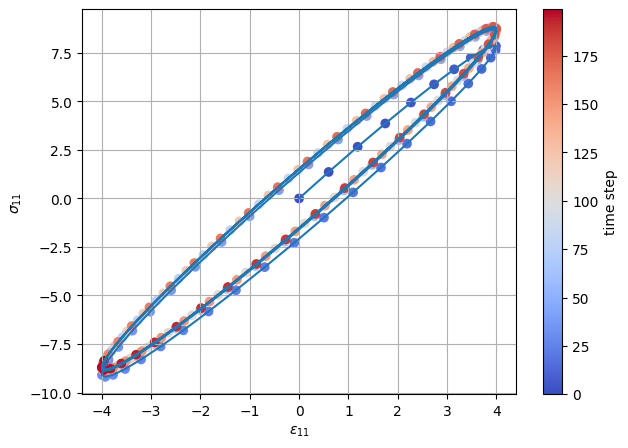

In [48]:
# material params
params = {
    "K": 1.0,
    "G": 1.0,
    "eta": 0.1
}

# strain history
n_ts = 200
ts = jnp.linspace(0., 1., n_ts)

# strain history (Voigt)
eps_xx = 4.0 * jnp.sin(ts * 30.0)
epsilon_ts = (jnp.zeros((len(ts), 6)).at[:, 0].set(eps_xx))

# Δt: first step = ts[1] - ts[0], then forward differences
dt0 = ts[1] - ts[0]
delta_t = jnp.concatenate([jnp.array([dt0]), jnp.diff(ts)])

# Δε: first step = 0, then forward differences along time
zero6 = jnp.zeros((1, 6), dtype=epsilon_ts.dtype)
delta_epsilon = jnp.concatenate([zero6, epsilon_ts[1:] - epsilon_ts[:-1]], axis=0)

load_ts = {
    "t": ts,                       # (T,)
    "epsilon": epsilon_ts,         # (T, 6)
    "delta_t": delta_t,            # (T,)
    "delta_epsilon": delta_epsilon # (T, 6)
}

state0 = {"sigma": jnp.zeros(6),}
state_T, fields_ts, state_ts, logs_ts = simulate_unpack(constitutive_update_fn,state0, load_ts, params)

plt.figure(figsize=(7,5))
t = np.arange(len(eps11))
sc = plt.scatter(eps11, fields_ts["sigma"][:,0], c=t, cmap="coolwarm")
plt.colorbar(sc, label="time step")
eps11 = jnp.array(load_ts["epsilon"][:,0])
plt.plot(eps11,fields_ts["sigma"][:,0])
plt.grid()
plt.xlabel(r"$\epsilon_{11}$")
plt.ylabel(r"$\sigma_{11}$")
plt.show()

# Finite strain Neo-Hookean material under uniaxial load

This example requires the use of a Newton algorithm to solve for the unknown strains resulting from the unixial stress conditions. `newton_unravel` is that function, taking as argument a function that outputs a dictionary of residuals that needs to be zeroed, and an initial guess for solution x, which is itself a dictionary of intial guesses. The parameters of the residual function are passed as third argument to `newton_unravel`, followed by algorithmic parameters (which may be left to default values). The Newton algorithm computes the tangent dres/dx using jax forward mode automatic differentiation capabilities.

Notice also that stresses are here obtained from an hyperelastic potential by automatic differentiation (reverse mode) via
`grad_fun = jax.grad(lambda F_: psi_neo_hooke(F_, params))`

In [30]:
from simulation.simulate import simulate_unpack
from simulation.algebra import dev_voigt, norm_voigt, tensor_to_voigt
from simulation.newton import newton_unravel

def lame_from_E_nu(E, nu):
    mu  = E / (2.0*(1.0 + nu))
    lam = E*nu / ((1.0 + nu)*(1.0 - 2.0*nu))
    return lam, mu

def psi_neo_hooke(F, params):
    """
    Compressible Neo-Hookean potential (Simo style):
      ψ(F) = (μ/2) (I1 - 3 - 2 ln J) + (λ/2) (ln J)^2
    where I1 = tr(C), C = F^T F, J = det F.
    """
    lam, mu = lame_from_E_nu(params["E"], params["nu"])
    J = jnp.linalg.det(F)
    C = F.T @ F
    I1 = jnp.trace(C)
    logJ = jnp.log(jnp.clip(J, a_min=1e-16))   # guard
    return 0.5*mu*(I1 - 3.0 - 2.0*logJ) + 0.5*lam*(logJ**2)

def P_from_F(F, params):
    """First Piola-Kirchhoff stress P = ∂ψ/∂F, via JAX autodiff."""
    grad_fun = jax.grad(lambda F_: psi_neo_hooke(F_, params))
    return grad_fun(F)

def cauchy_from_F(F, params):
    P = P_from_F(F, params)
    J = jnp.linalg.det(F)
    Js = jnp.clip(J, a_min=1e-16)
    sigma = (P @ F.T) / Js
    return tensor_to_voigt(sigma)

# ---------- Residuals: solve for selected entries of F so that σ[idx] = 0 ----------
def _set_F_entries(F, flat_indices, values):
    Ff = F.reshape(-1)
    Ff = Ff.at[flat_indices].set(values)
    return Ff.reshape(3,3)

def residuals(x, F_given, params, sigma_idx, F_cstr_idx):
    """
    x: {"F_cstr": (k,)}  unknown free entries of F at flat indices F_cstr_idx (row-major).
    F_given: prescribed F with some entries already set by the load.
    sigma_idx: Voigt indices where σ must be zero (e.g., [1,2,3,4,5] for uniaxial stress in x).
    F_cstr_idx: flat indices (0..8) of F entries to solve for (e.g., [4,8] for F_yy, F_zz).
    """
    F_eff = _set_F_entries(F_given, F_cstr_idx, x["F_cstr"])
    sigma = cauchy_from_F(F_eff, params)
    return {"res_cstr": sigma[sigma_idx]}

# ---------- Update function (pure; no history) ----------
def constitutive_update_fn(state_old, step_load, params, alg={"tol":1e-10, "abs_tol":1e-14, "max_it":60}):
    F       = step_load["F"]
    sigma_idx  = step_load["sigma_cstr_idx"]
    F_cstr_idx = step_load["F_cstr_idx"]

    # ---- warm-start from previous F_eff ----
    F_eff_prev = state_old.get("F_eff", jnp.eye(3, dtype=F.dtype))
    z0 = F_eff_prev.reshape(-1)[F_cstr_idx]      # initial guess for unknown entries

    # Newton only on F_cstr
    x0 = {"F_cstr": z0}
    x_sol, iters = newton_unravel(
        residuals, x0, (F, params, sigma_idx, F_cstr_idx),
        tol=alg["tol"], abs_tol=alg["abs_tol"], max_iter=alg["max_it"]
    )

    F_eff = _set_F_entries(F, F_cstr_idx, x_sol["F_cstr"])
    sigma = cauchy_from_F(F_eff, params)

    # ---- store F_eff for the next step ----
    new_state = {"F_eff": F_eff}
    fields    = {"sigma": sigma, "F_eff": F_eff}
    logs      = {"conv": jnp.asarray(iters, dtype=jnp.int32)}
    return new_state, fields, logs

iters (first 10): [0 5 5 4 4 4 4 4 4 4]
first 3 solved [F_yy, F_zz, F_xy, F_xz, F_yz]:
 [[[1.         0.         0.        ]
  [0.         1.         0.        ]
  [0.         0.         1.        ]]

 [[1.55555556 0.         0.        ]
  [0.         0.86964096 0.        ]
  [0.         0.         0.86964096]]

 [[2.11111111 0.         0.        ]
  [0.         0.78299206 0.        ]
  [0.         0.         0.78299206]]]
[0 1 2 3 4 5 6 7 8 9]


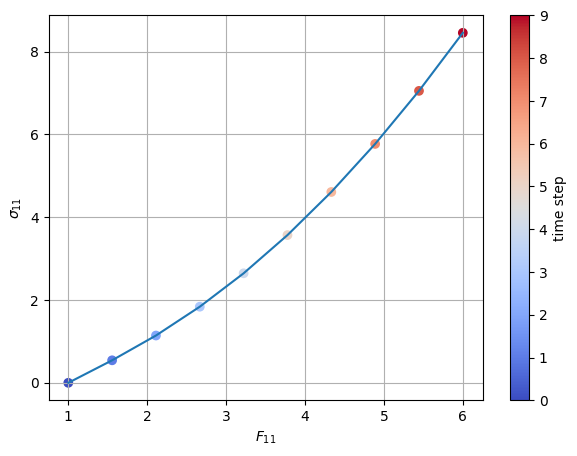

In [36]:
# ----- material -----
params = {"E": 1.0, "nu": 0.3}  # stiffer to make plots cleaner

# --- constraints (uniaxial stress in x) ---
# σ_yy, σ_zz, σ_yz, σ_zx, σ_xy = 0  -> Voigt indices [1,2,3,4,5]
sigma_cstr_idx = jnp.asarray([1, 2, 3, 4, 5])

# Unknown F entries (solve 5 unknowns ↔ 5 stress constraints):
# row-major flat indices 0..8 -> [[Fxx,Fxy,Fxz],[Fyx,Fyy,Fyz],[Fzx,Fzy,Fzz]]
# choose: F_yy, F_zz, F_xy, F_xz, F_yz
F_cstr_idx = jnp.asarray([4, 8, 1, 2, 5])

# ----- load history (F as input) -----
n_ts = 10
ts = jnp.linspace(0., 1., n_ts)

# axial stretch ABOUT 1 (e.g., ramp 1.00 -> 1.15)
lam_x = 1.0 + 5. * ts        # or 1.0 + 0.15*jnp.sin(2*jnp.pi*ts)

# start from identity each step, then overwrite F_xx
F_hist = jnp.tile(0.2*jnp.eye(3, dtype=jnp.float64), (len(ts), 1, 1))
F_hist = F_hist.at[:, 0, 0].set(lam_x)

load_ts = {
    "t": ts,
    "F": F_hist,
    "sigma_cstr_idx": jnp.broadcast_to(sigma_cstr_idx, (len(ts), sigma_cstr_idx.shape[0])) ,
    "F_cstr_idx": jnp.broadcast_to(F_cstr_idx, (len(ts), F_cstr_idx.shape[0])),
}

# ----- run -----
state0 = {"F_eff": jnp.eye(3, dtype=F_hist.dtype)}
state_T, fields_ts, state_ts, logs_ts = simulate_unpack(constitutive_update_fn,state0, load_ts, params)

print("iters (first 10):", logs_ts["conv"][:10])
print("first 3 solved [F_yy, F_zz, F_xy, F_xz, F_yz]:\n", fields_ts["F_eff"][:3])

t = np.arange(len(fields_ts["F_eff"]))
print(t)
plt.figure(figsize=(7,5))
sc = plt.scatter(fields_ts["F_eff"][:,0,0], fields_ts["sigma"][:,0], c=t, cmap="coolwarm")
plt.colorbar(sc, label="time step")
plt.plot(fields_ts["F_eff"][:,0,0],fields_ts["sigma"][:,0])
plt.grid()
plt.xlabel(r"$F_{11}$")
plt.ylabel(r"$\sigma_{11}$")
plt.show()

# Plasticity example



In [13]:
from jax import lax

from simulation.simulate import simulate_unpack
from simulation.algebra import dev_voigt, norm_voigt
from simulation.newton import newton_implicit_unravel

def C_iso_voigt(E, nu):
    mu  = E / (2.0 * (1.0 + nu))
    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    lam2 = lam + 2.0 * mu
    return jnp.array([
        [lam2, lam,  lam,  0., 0., 0.],
        [lam,  lam2, lam,  0., 0., 0.],
        [lam,  lam,  lam2, 0., 0., 0.],
        [0.,   0.,   0.,   mu, 0., 0.],
        [0.,   0.,   0.,   0., mu, 0.],
        [0.,   0.,   0.,   0., 0., mu],
    ])

def R_iso(p, Q, b):
    return Q * (1.0 - jnp.exp(-b * p))

def vm(sigma):
    s = dev_voigt(sigma)
    return jnp.sqrt(3.0/2.0) * norm_voigt(s)

def f_func(sigma, p, sigma_y, Q, b):
    return vm(sigma) - (sigma_y + R_iso(p,Q,b))

def residuals(x, step_load, state_old, params):

    epsilon   = step_load["epsilon"]
    E, nu  = params["E"], params["nu"]
    sigma_y, Q, b = params["sigma_y"], params["Q"], params["b"]
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]

    sigma, eps_p, p = x["sigma"], x["eps_p"], x["p"]

    C = C_iso_voigt(E, nu)
    sig_trial = C @ (epsilon - eps_p_old)
    f_trial   = f_func(sig_trial, p_old, sigma_y, Q, b)
    H = jnp.heaviside(f_trial , 1.)

    res_sigma = sigma - C @ (epsilon - eps_p)

    df_dsigma = jax.grad(lambda s: f_func(s, p, sigma_y, Q, b))(sigma)
    res_epsp  = (eps_p - eps_p_old) - (p - p_old) * df_dsigma

    res_p = f_func(sigma, p, sigma_y, Q, b) * H + (1.0 - H) * (p - p_old)

    return {"res_sigma": res_sigma, "res_epsp": res_epsp, "res_p": res_p}

def initialize(step_load,state_old,params):

    epsilon   = step_load["epsilon"]
    E, nu  = params["E"], params["nu"]
    sigma_y, Q, b = params["sigma_y"], params["Q"], params["b"]
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]

    C = C_iso_voigt(E, nu)
    sigma_trial = C @ (epsilon - eps_p_old)
    f_trial     = f_func(sigma_trial, p_old, sigma_y, Q, b)

    x0 = { "sigma": sigma_trial, "eps_p": eps_p_old, "p": jnp.asarray(p_old) }

    return x0

def unpack(x_sol,iters):

    # we need to redefine the structure as jax does not accept mutations
    new_state = {"epsilon_p": x_sol["eps_p"], "p": x_sol["p"]}
    fields    = {"sigma": x_sol["sigma"]}
    logs      = {"conv": jnp.asarray(iters)}

    return new_state, fields, logs

# ----------------- constitutive update (pure function) -----------------
def constitutive_update_fn(state_old, step_load, params, alg = {"tol" :1e-8, "abs_tol":1e-12, "max_it":100}):
    x0 = initialize(step_load,state_old,params)
    x_sol, iters = newton_unravel(
        residuals, x0, (step_load, state_old, params),
        tol=alg["tol"], abs_tol=alg["abs_tol"], max_iter=alg["max_it"]
    )
    #x_sol, iters = newton_optx(
    #    residuals, x0, (step_load, state_old, params),
    #    tol=alg["tol"], abs_tol=alg["abs_tol"], max_iter=alg["max_it"]
    #)
    new_state, fields, logs = unpack(x_sol, iters)
    return new_state, fields, logs

★ JIT compile + first run: 0.003594 sec
iteration count (first 100) [0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2]


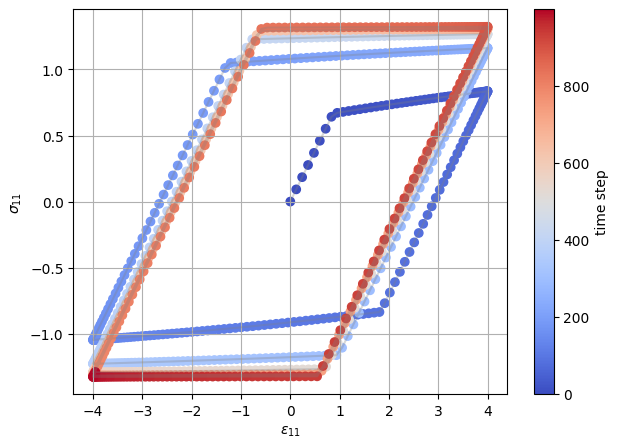

In [24]:
# material params
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "E" : 1.0,
    "nu": 0.3,
}

# strain history
n_ts = 1000
ts = jnp.linspace(0., 1., n_ts)
eps_xx = 4.0 * jnp.sin(ts * 30.0)
epsilon_ts = (jnp.zeros((n_ts, 6))
              .at[:, 0].set(eps_xx)
              .at[:, 1].set(-0.5 * eps_xx)
              .at[:, 2].set(-0.5 * eps_xx))

load_ts={"epsilon": epsilon_ts}

state0 = {"epsilon_p": jnp.zeros(6), "p": jnp.array(0.0)}
t0 = time.time()
state_T, fields_ts, state_ts, logs_ts = simulate_unpack(constitutive_update_fn,state0, load_ts, params)
block_until_ready(state_T_j1)
t_jit_compile = time.time() - t0
print(f"★ JIT compile + first run: {t_jit_compile:.6f} sec")

print("iteration count (first 100)",logs_ts["conv"][:100])

import numpy as np
eps11 = np.array(load_ts["epsilon"][:,0])
sigma11 = np.array(fields_ts["sigma"][:,0])
t = np.arange(len(eps11))
plt.figure(figsize=(7,5))
sc = plt.scatter(eps11, sigma11, c=t, cmap="coolwarm")
plt.colorbar(sc, label="time step")
plt.plot(eps11, sigma11, color="gray", alpha=0.3)  # faint connecting line
plt.xlabel(r"$\epsilon_{11}$")
plt.ylabel(r"$\sigma_{11}$")
plt.grid(True)
plt.show()

In [21]:
# -----------------------------------------------
# Second jitted run (execution only)
# -----------------------------------------------
t0 = time.time()
state_T_j2, fields_ts_j2, state_ts_j2, logs_ts_j2 = simulate_unpack(
    constitutive_update_fn, state0, load_ts, params
)
block_until_ready(state_T_j2)
t_jit_run = time.time() - t0

print(f"★ JIT warm run (exec only): {t_jit_run:.6f} sec")

★ JIT warm run (exec only): 3.216209 sec


In [22]:
# -----------------------------------------------
# 2) First jitted run (compilation + execution)
# -----------------------------------------------
t0 = time.time()
state_T_j1, fields_ts_j1, state_ts_j1, logs_ts_j1 = simulate_unpack(
    constitutive_update_fn, state0, load_ts, params
)
block_until_ready(state_T_j1)
t_jit_compile = time.time() - t0

print(f"★ JIT compile + first run: {t_jit_compile:.6f} sec")



★ JIT compile + first run: 0.005253 sec


# A more concise (specialized) API.

This is an API that is specialised for the case where the constitutive update is a esentially a Newton algorthm. In this cas, one just need to provide a factory that builds functions for the initialisation of the Newton algorithm, for the calculation of the residual and for the unpacking of solution dictionary to update the internal state and populate outputs dictionaries `fields` and `logs`. This factory is passed to simulator `make_simulate_unpack`

Alternatively, the `unpack` function may be ignored by using  `make_simulate_auto_unpack` (not bullet proof yet) and outputting only the residual and intialization functions from the factory. In that case, the internal state is automatically updated from the solution of the Newton system by looking for the keys in unknown vector x that have been defined through the initialisation of the internal state. All other fields of x are saved in dictionary "fields". logs are automatically created to inspect the number of iterations to convergence.

In [37]:
from simulation.simulate import make_simulate_unpack
from simulation.algebra import dev_voigt, norm_voigt, voigt_to_tensor, tensor_to_voigt

from functools import partial
from jax.scipy.linalg import solve as la_solve

def C_iso_voigt(E, nu):
    mu  = E / (2.0 * (1.0 + nu))
    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    lam2 = lam + 2.0 * mu
    return jnp.array([
        [lam2, lam,  lam,  0., 0., 0.],
        [lam,  lam2, lam,  0., 0., 0.],
        [lam,  lam,  lam2, 0., 0., 0.],
        [0.,   0.,   0.,   mu, 0., 0.],
        [0.,   0.,   0.,   0., mu, 0.],
        [0.,   0.,   0.,   0., 0., mu],
    ])

def Hooke_law_voigt(eps_e, E, nu):
    lam = E*nu / ((1 + nu) * (1 - 2*nu))
    mu  = E / (2 * (1 + nu))
    I = jnp.eye(3, dtype=eps_e.dtype)
    eps_e_tens = voigt_to_tensor(eps_e)
    sig_tens = lam*jnp.trace(eps_e_tens)*I+2*mu*eps_e_tens
    return tensor_to_voigt(sig_tens)

def R_iso(p, Q, b):
    return Q * (1.0 - jnp.exp(-b * p))

def vm(sigma):
    s = dev_voigt(sigma)
    return jnp.sqrt(3.0/2.0) * norm_voigt(s)

def f_func(sigma, p, sigma_y, Q, b):
    return vm(sigma) - (sigma_y + R_iso(p,Q,b))

def Fischer_Burmeister(a,b):
    return jnp.sqrt(a**2+b**2)-a-b # ϕ(a,b)=0 ⟺ a≥0,b≥0,ab=0

# Solve for z = eps_cstr_trial so that (C @ (epsilon_eff - eps_p_old))[sigma_idx] = 0
# epsilon_eff[sigma_idx] = eps_cstr_trial
def solve_eps_cstr(epsilon,eps_p_old,sigma_idx,C):
    A = C[sigma_idx][:, sigma_idx]                                                 # (k,k)
    r = (C @ (epsilon - eps_p_old))[sigma_idx]                                     # (k,)
    dz = la_solve(A, r, assume_a='gen')                                            # (k,)
    eps_cstr_trial = epsilon[sigma_idx] - dz
    return epsilon.at[sigma_idx].set(eps_cstr_trial) , eps_cstr_trial

def make_newton(state_old, step_load, params):

    epsilon = step_load["epsilon"]
    sigma_idx = step_load.get("sigma_cstr_idx")

    E, nu  = params["E"], params["nu"]
    sigma_y, Q, b = params["sigma_y"], params["Q"], params["b"]

    C = C_iso_voigt(E, nu)

    eps_p_old, p_old , X_old = state_old["epsilon_p"], state_old["p"], state_old["X"]

    epsilon_eff_trial, eps_cstr_trial = solve_eps_cstr(epsilon,eps_p_old,sigma_idx,C)
    sigma_trial = C @ (epsilon_eff_trial - eps_p_old)

    f_trial = f_func(sigma_trial-X_old, p_old, sigma_y, Q, b)
    H = jnp.heaviside(f_trial , 1.)

    def residuals(x):

        sigma, eps_p, p, X = x["sigma"], x["epsilon_p"], x["p"], x["X"]

        epsilon_eff = epsilon.at[sigma_idx].set(x["eps_cstr"])

        #res_sigma = sigma - Hooke_law_voigt(epsilon_eff - eps_p, E, nu)
        res_sigma = sigma - C @ (epsilon_eff - eps_p)

        df_dsigma = jax.grad(lambda s: f_func(s-X, p, sigma_y, Q, b))(sigma)
        res_epsp  = (eps_p - eps_p_old) - (p - p_old) * df_dsigma

        #res_p = f_func(sigma-X, p, sigma_y, Q, b) * H + (1.0 - H) * (p - p_old)

        res_p = Fischer_Burmeister( -f_func(sigma-X, p, sigma_y, Q, b) , p-p_old )

        res_X = (X - X_old) - ( 2./3. * params['C_kin'] * (eps_p-eps_p_old) - params['D_kin'] * X * (p-p_old) )

        res_cstr = sigma[sigma_idx]

        res = {"res_sigma": res_sigma, "res_epsp": res_epsp, "res_p": res_p, "res_X": res_X, "res_cstr": res_cstr}
        #print(step_load['t'],res)
        return res

    def initialize_newton():
        return { "sigma": sigma_trial, "eps_cstr": eps_cstr_trial, **state_old }

    def unpack(x): # we need to redefine the structure as jax does not accept mutations
        state = {"epsilon_p": x["epsilon_p"], "p": x["p"], "X": x["X"]}
        fields = {"sigma": x["sigma"]}
        return state, fields

    return residuals, initialize_newton, unpack

def initialize_state():
    return {"epsilon_p": jnp.zeros(6,), "p": jnp.array(0.0), "X": jnp.zeros(6,)}

iteration count (first 100) [1 1 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 1 1
 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5
 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1 1 1]


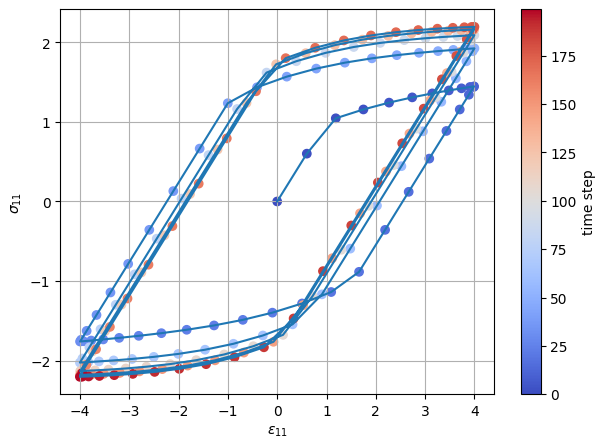

In [39]:
# material params
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "C_kin": 0.25 ,
    "D_kin": 1.0 ,
    "E" : 1.0,
    "nu": 0.3,
}

n_ts = 200
ts = jnp.linspace(0., 1., n_ts)
eps_xx = 4.0 * jnp.sin(ts * 30.0)
epsilon_ts = jnp.zeros((n_ts, 6)).at[:, 0].set(eps_xx)

sigma_cstr_idx = jnp.asarray([1, 2, 3, 4, 5])

load_ts = {
        "t": ts,
        "epsilon": epsilon_ts,
        "sigma_cstr_idx": jnp.broadcast_to(sigma_cstr_idx, (len(ts), sigma_cstr_idx.shape[0]))
        }

#jax.config.update("jax_disable_jit", False)   # turn JIT on
#jax.config.update("jax_disable_jit", True)   # turn JIT off

state0 = initialize_state()
state_T, fields_ts, state_ts, logs_ts = make_simulate_unpack(make_newton, state0, load_ts, params)

#jax.config.update("jax_disable_jit", False)   # turn JIT on

print("iteration count (first 100)",logs_ts["conv"][:100])

eps11 = jnp.array(load_ts["epsilon"][:,0])

t = np.arange(len(eps11))
plt.figure(figsize=(7,5))
sc = plt.scatter(eps11, fields_ts["sigma"][:,0], c=t, cmap="coolwarm")
plt.colorbar(sc, label="time step")
plt.plot(eps11,fields_ts["sigma"][:,0])
plt.grid()
plt.xlabel(r"$\epsilon_{11}$")
plt.ylabel(r"$\sigma_{11}$")
plt.show()

# Basic calibration example (run "a more concise ... section first")

- find the two parameters of an exponential isotropic hardening law $R(p)=Q(1-e^{-bp})$

We provide `build_param_space` that outputs a mapping of real parameters defined over the real space to user defined hypercubes. The API is restricted to contexts where upper and lower bounds are available, i.e. no one-sided constraints. The use may specify whether the parameters should be looked for in log spaces or not, by providing keyword `"scale": "log"` when appropriate. `build_param_space` also provides an initialization of the active parametsers as the mid-point of the admissible interval (possibly in log-scaling).

Note that the space object also contains the information about frozen parameters that will not be optimized.

`make_loss` requires a space object and a fonction that computes a scalar loss given an dicitonary of parameters (active and frozen). This loss can be minimised by `bfgs`, making use of reverse mode autodiff to compute loss sensitivites.

In [40]:
from jax import lax, jit
from jax.scipy.linalg import solve as la_solve

from simulation.simulate import simulate
from simulation.algebra import dev_voigt, norm_voigt
from optimization.optimizers import bfgs
from optimization.parameter_mappings import build_param_space, make_loss, to_params

# save reference solution for inverse problem
true_params = params.copy()
sigma_xx_obs = fields_ts["sigma"][:, 0]

In [41]:
print("-----------------------------------------------")
print("active/frozen parameter ranges and distribution")
print("-----------------------------------------------")


# --- declare frozen + active (bounds + scale). Omit values in init_params to use interval midpoints ---
init_params = {
    "nu": 0.3,
    "E": 1.,
    "sigma_y": 1.,  # frozen values supplied
    # "Q": (omitted -> defaults to geom. mean of bounds)
    # "b": (omitted -> defaults to geom. mean of bounds)
    "C_kin": 0.25, "D_kin": 1.0,          # frozen for this example
}

active_specs = {
    #"nu": False,
    #"E": {"lower": 1.e-1, "upper": 1.e+1, "scale": "log", "mask": None},
    #"sigma_y": {"lower": 0.5, "upper": 3.e0, "scale": "linear", "mask": None},
    "Q": {"lower": 1.e-3, "upper": 1.e+2, "scale": "log", "mask": None},
    "b": {"lower": 1.e-3, "upper": 1.e+0, "scale": "log", "mask": None},
    "C_kin": {"lower": 1.e-1, "upper": 1.e1, "scale": "log", "mask": None},
    "D_kin": {"lower": 1.e-1, "upper": 1.e1, "scale": "log", "mask": None},
}

space, theta0 = build_param_space(init_params, active_specs)

print(space)

print("-----------------")
print("user-defined loss")
print("-----------------")


def forward_sigma11(params):
    state0 = initialize_state()
    state_T, fields_ts, state_ts, logs_ts = make_simulate_unpack(make_newton,state0, load_ts, params)
    return fields_ts["sigma"][:, 0]

def simulate_and_loss(params):
    pred = forward_sigma11(params)
    r = pred - sigma_xx_obs
    return 0.5 * jnp.mean(r * r)

loss = make_loss(space,simulate_and_loss)

-----------------------------------------------
active/frozen parameter ranges and distribution
-----------------------------------------------
{'init': {'C_kin': Array(0.25, dtype=float64, weak_type=True), 'D_kin': Array(1., dtype=float64, weak_type=True), 'E': Array(1., dtype=float64, weak_type=True), 'Q': Array(0.31622777, dtype=float64), 'b': Array(0.03162278, dtype=float64), 'nu': Array(0.3, dtype=float64, weak_type=True), 'sigma_y': Array(1., dtype=float64, weak_type=True)}, 'keys': ('C_kin', 'D_kin', 'E', 'Q', 'b', 'nu', 'sigma_y'), 'active_keys': ('C_kin', 'D_kin', 'Q', 'b'), 'idx_map': {'C_kin': Array([0], dtype=int32), 'D_kin': Array([0], dtype=int32), 'Q': Array([0], dtype=int32), 'b': Array([0], dtype=int32)}, 'shapes': {'C_kin': (), 'D_kin': (), 'Q': (), 'b': ()}, 'slices': {'C_kin': (0, 1), 'D_kin': (1, 2), 'Q': (2, 3), 'b': (3, 4)}, 'lowers': {'C_kin': Array([0.1], dtype=float64), 'D_kin': Array([0.1], dtype=float64), 'Q': Array([0.001], dtype=float64), 'b': Array([0.001

In [42]:
print("-------------")
print("run optimizer")
print("-------------")

init = to_params(space, theta0)
print("Initial Q, b:", init["Q"], init["b"])
print("Initial E:", init["E"])
print("Initial sigma_y:", init["sigma_y"])
print("Initial C_kin, D_kin:", init["C_kin"], init["D_kin"])


# --- run BFGS (optionally seed with a few Adam steps you have) ---
t0 = time.perf_counter()
theta_opt, fval, info = bfgs(loss, theta0, rtol=1.e-3, n_display=1)
t1 = time.perf_counter()
print("time for optimizaton:", (t1 - t0), "s")
print("final loss:", fval)
print("info",info)

# --- unpack physical identified parameters ---
identified = to_params(space, theta_opt)
print("Identified Q, b:", identified["Q"], identified["b"])
print("Identified E:", identified["E"])
# Optional: get fitted curve

-------------
run optimizer
-------------
Initial Q, b: 0.31622776601683805 0.0316227766016838
Initial E: 1.0
Initial sigma_y: 1.0
Initial C_kin, D_kin: 0.25 1.0
[BFGS] it 0: f=1.604906e-01, ||g||=4.534e-01
[BFGS] it 1: f=5.358084e-03, ||g||=1.798e-01, alpha=7.500e-01, fe=4, ge=4
[BFGS] it 2: f=2.608826e-03, ||g||=1.548e-02, alpha=1.250e-01, fe=8, ge=8
[BFGS] it 3: f=2.474498e-03, ||g||=1.130e-02, alpha=1.000e+00, fe=9, ge=9
[BFGS] it 4: f=1.610692e-03, ||g||=5.010e-02, alpha=1.000e+00, fe=10, ge=10
[BFGS] it 5: f=1.403566e-03, ||g||=1.793e-02, alpha=1.000e+00, fe=11, ge=11
[BFGS] it 6: f=1.289951e-03, ||g||=1.572e-02, alpha=1.000e+00, fe=12, ge=12
[BFGS] it 7: f=1.149067e-03, ||g||=2.948e-02, alpha=1.000e+00, fe=13, ge=13
[BFGS] it 8: f=8.217737e-04, ||g||=1.073e-02, alpha=2.000e+00, fe=15, ge=15
[BFGS] it 9: f=6.475325e-04, ||g||=9.839e-03, alpha=1.000e+00, fe=16, ge=16
[BFGS] it 10: f=4.505790e-04, ||g||=8.543e-03, alpha=2.000e+00, fe=18, ge=18
[BFGS] it 11: f=3.553255e-04, ||g||=5.

-----------
plot result
-----------


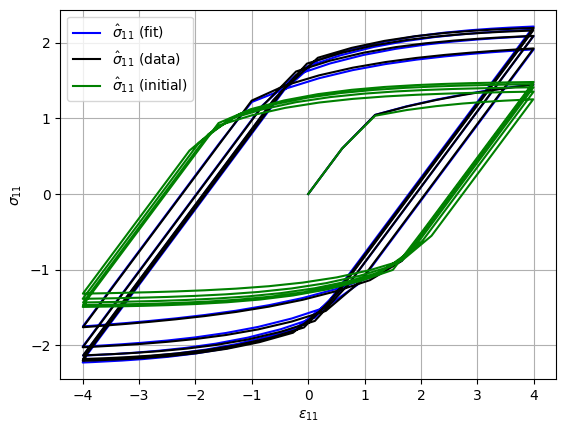

In [43]:
print("-----------")
print("plot result")
print("-----------")

sigma_fit = forward_sigma11(identified)
sigma_init = forward_sigma11(init)

plt.plot(load_ts['epsilon'][:,0],sigma_fit,'blue',label=r'$\hat{\sigma}_{11}$ (fit)')
plt.plot(load_ts['epsilon'][:,0],sigma_xx_obs,'black',label=r'$\hat{\sigma}_{11}$ (data)')
plt.plot(load_ts['epsilon'][:,0],sigma_init,'green',label=r'$\hat{\sigma}_{11}$ (initial)')
plt.legend(loc='best')
plt.xlabel(r"$\epsilon_{11}$")
plt.ylabel(r"$\sigma_{11}$")
plt.grid()
plt.show()

In [44]:
print("--------------")
print("test CPU times")
print("--------------")

v_ = loss(theta0).block_until_ready()
_ = jax.grad(loss)(theta0).block_until_ready()  # warm both paths

t0 = time.perf_counter()
f = loss(theta0).block_until_ready()
t1 = time.perf_counter()
print("one forward loss eval:", (t1 - t0) * 1e3, "ms")

t0 = time.perf_counter()
g = jax.grad(loss)(theta0).block_until_ready()
t1 = time.perf_counter()
print("one grad eval:", (t1 - t0) * 1e3, "ms")

--------------
test CPU times
--------------
one forward loss eval: 38.17469699993126 ms
one grad eval: 63.948359000050914 ms


# Advanced : Bayesian inference (MALA)

In `build_param_space`, the transformation of parameters to be optimised in unconstrained space to real-scale parameters is done via transformed sigmoids. The base sigmoid is the cumulative normal distribution, which allows us to introduce a multivariate normal priori for the unconstrained variables, resultiung in a uniform prior (possibly log-uniform) over the user-defined hypercube for the real parameters. This is leverage below by running a MALA algorithm for probabilistic parameter identification et uncertianty propagation. Again, the reverse mode autodiff capabilities of jax are leveraged in the MALA algorithm to compute the deterministic part of each random move.

Note: you can set `noise_std = 1.e+6` (i.e. very noisy measurements) to obtain a sampling of the prior

In [ ]:
from optimization.samplers import *

print("--------------------------")
print("mala for posterior density")
print("--------------------------")

def loglik(theta):
    # Drop the normalization constant (it doesn't depend on theta and cancels in MALA/MH).
    # i.i.d. N(0, σ^2): log p(y|θ,σ) = const - (1/(σ^2)) * 0.5*sum r^2
    noise_std = 5.e-2
    return -(0.5 / (noise_std**2)) * loss(theta)
    #return 0.

run_mala = make_mala_unit_gaussian_prior(loglik)

print("theta0",theta0)
print("theta_opt",theta_opt)

key = random.PRNGKey(0)
samples, acc_rate = run_mala(
    key,
    theta_opt,
    eps=3.e-2,
    n_steps=1000,
    burn=250,
    thin=1,
)

print("MALA acceptance rate:", float(acc_rate))

In [ ]:
import numpy as np
pts = np.asarray(samples, dtype=np.float32)
#plt.scatter(pts[:,0],pts[:,1], s=10, alpha=0.6)
plt.scatter(pts[:,0],pts[:,1],c=np.arange(len(pts)),cmap='coolwarm',s=10,alpha=0.8)
plt.xlabel('log(mu1) in normalised space')
plt.ylabel('log(mu2) in normalised space')
plt.grid()
plt.title('posterior sampling - normalised parameter logs')
plt.show()

params = map_to_params(space, samples)

Q = jax.device_get(params["Q"]).ravel()
b = jax.device_get(params["b"]).ravel()

plt.figure()
#plt.scatter(jnp.log10(Q), jnp.log10(b), s=10, alpha=0.6)  # x=Q, y=b
plt.scatter(jnp.log10(Q), jnp.log10(b), c=np.arange(len(Q)),cmap='coolwarm',s=10,alpha=0.8)
plt.xlabel(r'$\log_{10}(Q)$')
plt.ylabel(r'$\log_{10}(b)$')
plt.grid(True)
plt.title('posterior sampling')
plt.show()

plt.figure()
sc = plt.scatter(Q, b,c=np.arange(len(Q)),cmap='coolwarm',s=10,alpha=0.8)
plt.xlabel("Q")
plt.ylabel("b")
plt.grid(True)
plt.title("posterior sampling")
plt.colorbar(sc, label="sample index")  # optional but nice
plt.show()

In [ ]:
print("------------------------------------------------")
print("parameter summaries and predictive distributions")
print("------------------------------------------------")

# Posterior summaries in parameter space (dict: name -> (mean, p05, p95))
param_summ = posterior_param_summary(samples, space)
# Returns a dict: {name: (mean, p05, p95)}
print("param_summ",param_summ['b'])
print("param_summ",param_summ['Q'])

# Predictive band for σ11(t)
idx = np.random.choice(len(samples), size=min(len(samples), 100), replace=False)
subset = samples[idx]
sigma_mean, sigma_p05, sigma_p95, sigma_samples = posterior_predictive(subset,space,forward_sigma11) # slow, to be checked

# Example: if you want the posterior mean physical-parameter dict:
# mean_params = jax.tree_map(lambda trio: trio[0], param_summ)

plt.plot(sigma_p05,'blue')
plt.plot(sigma_p95,'red')
plt.plot(sigma_xx_obs,'black')
plt.ylabel(r'$\sigma_{11}$')
plt.xlabel('t')
plt.grid()
plt.show()

# vicoplasticity + Optimistix as solver and use of jax vmap for batched computations

In [ ]:
try:
    import optimistix
except:
    !pip install optimistix
from simulation.newton import newton_optx

In [ ]:
def C_iso_voigt(E, nu):
    mu  = E / (2.0 * (1.0 + nu))
    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    lam2 = lam + 2.0 * mu
    return jnp.array([
        [lam2, lam,  lam,  0., 0., 0.],
        [lam,  lam2, lam,  0., 0., 0.],
        [lam,  lam,  lam2, 0., 0., 0.],
        [0.,   0.,   0.,   mu, 0., 0.],
        [0.,   0.,   0.,   0., mu, 0.],
        [0.,   0.,   0.,   0., 0., mu],
    ])

# ----------------- constitutive update (pure function) -----------------
def R_iso(p, params):
    return params["Q"] * (1.0 - jnp.exp(-params["b"] * p))

def vm(sigma):
    s = dev_voigt(sigma)
    return jnp.sqrt(3.0/2.0) * norm_voigt(s)

def f_func(sigma, p, sigma_y, Q, b):
    return vm(sigma) - (params["sigma_y"] + R_iso(p, params))

def Fischer_Burmeister(a,b):
    return jnp.sqrt(a**2+b**2)-a-b # ϕ(a,b)=0 ⟺ a≥0,b≥0,ab=0

def residuals(x, step_load, state_old, params):
    # unpack unknowns
    sigma = x["sigma"]
    eps_p = x["eps_p"]
    p     = x["p"]
    eps_cstr = x["eps_cstr"]

    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]

    K_visco = params["K"]
    n_visco = params["n"]

    E = params["E"]
    nu = params["nu"]
    sigma_y = params["sigma_y"]

    epsilon = step_load["epsilon"]
    sigma_idx = step_load.get("sigma_cstr_idx")
    dt = step_load["delta_t"]

    # effective total strain with constraint dof
    epsilon_eff = epsilon.at[sigma_idx].set(eps_cstr)

    # elastic residual (Hooke in Voigt notation)
    res_sigma = sigma - Hooke_law_voigt(epsilon_eff - eps_p, E, nu)

    # plastic flow direction df/dsigma
    def f_sigma(s):
        return f_func(s, p, sigma_y, Q, b)

    df_dsigma = jax.grad(f_sigma)(sigma)

    # plastic strain residual
    res_epsp = (eps_p - eps_p_old) - (p - p_old) * df_dsigma

    # viscoplastic residual with ReLU and double-where style safety
    phi = f_func(sigma, p, sigma_y, Q, b)    # overstress-like yield function value

    # Perzyna-type positive-part: <phi/K_visco>_+ using ReLU
    y = phi / K_visco
    overstress = jax.nn.relu(y)              # >= 0

    # condition: only phi > 0 contributes viscoplastic flow
    cond = phi > 0.0
    # ---- double-where / safe-input trick ----
    overstress_safe = jnp.where(cond, overstress, 1.0)
    # dangerous power only sees safe inputs
    g = jnp.where(cond, overstress_safe**n_visco, 0.0)
    res_p = (p - p_old) / dt - g

    # constraint residual on selected stress component
    res_cstr = sigma[sigma_idx]

    return {
        "res_sigma": res_sigma,
        "res_epsp":  res_epsp,
        "res_p":     res_p,
        "res_cstr":  res_cstr,
    }

def residuals_diff_split(x, diff_args, nondiff_args):
    params = diff_args
    step_load, state_old = nondiff_args
    return residuals(x, step_load, state_old, params)

def solve_eps_cstr(epsilon,eps_p_old,sigma_idx,params):
    C = C_iso_voigt(params["E"], params["nu"])
    A = C[sigma_idx][:, sigma_idx]                                                 # (k,k)
    r = (C @ (epsilon - eps_p_old))[sigma_idx]                                     # (k,)
    dz = la_solve(A, r, assume_a='gen')                                            # (k,)
    eps_cstr_trial = epsilon[sigma_idx] - dz
    return epsilon.at[sigma_idx].set(eps_cstr_trial) , eps_cstr_trial

def initialize_newton(state_old, step_load, params):
    C = C_iso_voigt(params["E"], params["nu"])
    eps_p_old, p_old = state_old["epsilon_p"], state_old["p"]
    dtype = C.dtype

    epsilon   = step_load["epsilon"]
    sigma_idx = step_load.get("sigma_cstr_idx")

    epsilon_eff_trial , eps_cstr_trial = solve_eps_cstr(epsilon,eps_p_old,sigma_idx,params)
    sigma_trial       = C @ (epsilon_eff_trial - eps_p_old)

    x0 = {
        "sigma":    sigma_trial,
        "eps_p":    eps_p_old,
        "p":        jnp.asarray(p_old, dtype=dtype),
        "eps_cstr": jnp.asarray(eps_cstr_trial, dtype=dtype),  # good initial guess
    }
    return x0

def unpack(x_sol, iters):
    new_state = {"epsilon_p": x_sol["eps_p"], "p": x_sol["p"]}
    fields    = {"sigma": x_sol["sigma"]}
    logs      = {"conv": jnp.asarray(iters),
                    "eps_cstr": x_sol["eps_cstr"]}
    return new_state, fields, logs

def constitutive_update_fn(state_old, step_load, params, alg = {"tol" :1e-8, "abs_tol":1e-12, "max_it":100}):
    x0 = initialize_newton(state_old, step_load, params)
    nondiff_args = (step_load, state_old)
    diff_args = params
    x_sol, iters = newton_optx(
        residuals_diff_split,  # the new residual with split args
        x0,diff_args,nondiff_args,
        tol=alg["tol"],
        abs_tol=alg["abs_tol"],
        max_iter=alg["max_it"],
    )
    new_state, fields, logs = unpack(x_sol, iters)
    return new_state, fields, logs

def initialize_state():
    return {"epsilon_p": jnp.zeros(6,), "p": jnp.array(0.0)}

In [ ]:
print("--------------------")
print("reference simulation")
print("--------------------")

# material params
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "E" : 1,
    "nu": 0.3,
    "K" : 0.001,
    "n": 1.0,
}

# strain history
n_ts = 1000
ts = jnp.linspace(0., 1., n_ts)

omega = 30.0
alpha = 5.0
t0 = 0.5

phase_second = alpha * omega * ts + (1.0 - alpha) * omega * t0

eps_xx = 4.0 * jnp.where(
    ts <= t0,
    jnp.sin(omega * ts),
    jnp.sin(phase_second),
)

epsilon_ts = (jnp.zeros((n_ts, 6))
                .at[:, 0].set(eps_xx)
                .at[:, 1].set(-0.5 * eps_xx)
                .at[:, 2].set(-0.5 * eps_xx))

dt0 = ts[1] - ts[0]
delta_t = jnp.concatenate([jnp.array([dt0]), jnp.diff(ts)])

sigma_cstr_idx = jnp.asarray([1, 2, 3, 4, 5])

load_ts = {"epsilon": epsilon_ts, "delta_t": delta_t, "sigma_cstr_idx": jnp.broadcast_to(sigma_cstr_idx, (len(ts), sigma_cstr_idx.shape[0])) }

state0 = initialize_state()
state_T, fields_ts, state_ts, logs_ts = simulate_unpack(
    constitutive_update_fn, state0, load_ts, params
)

print("iteration count (first 100)", logs_ts["conv"][:100])

eps11 = jnp.array(load_ts["epsilon"][:, 0])
plt.plot(eps11, fields_ts["sigma"][:, 0])
plt.grid()
plt.xlabel(r"$\epsilon_{11}$")
plt.ylabel(r"$\sigma_{11}$")
plt.show()

In [ ]:
def plot_batch(load_ts, fields_ts_batch):
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract sigma batch
    sigma_batch = np.array(fields_ts_batch["sigma"])      # (B, n_ts, 6)
    B, n_ts, _ = sigma_batch.shape

    # Extract epsilon
    eps = np.array(load_ts["epsilon"])

    # If epsilon is batched: (B, n_ts, 6)
    if eps.ndim == 3:
        eps11_batch = eps[:, :, 0]                        # (B, n_ts)
    # If epsilon is single-path: (n_ts, 6)
    else:
        eps11 = eps[:, 0]                                 # (n_ts,)
        eps11_batch = np.broadcast_to(eps11, (B, n_ts))   # make B copies

    plt.figure()
    for i in range(B):
        plt.plot(eps11_batch[i], sigma_batch[i, :, 0])    # σ11 vs ε11 for batch i

    plt.grid(True)
    plt.xlabel(r"$\varepsilon_{11}$")
    plt.ylabel(r"$\sigma_{11}$")
    plt.show()

print("---------------------------------------------")
print("batched simulation case 1: several parameters")
print("---------------------------------------------")


# 1) Wrap simulate into a single-sample function
def run_one(params, load_ts, state0):
    # simulate(update_fn, state0, load_ts, params)
    state_T, fields_ts, state_ts, logs_ts = simulate_unpack(constitutive_update_fn,state0, load_ts, params)
    return state_T, fields_ts, state_ts, logs_ts

# 2) Vectorize over the first axis of params
batched_run = jax.vmap(run_one, in_axes=(0,  None,   None))  # params batched, load_ts & state0 shared

# 3) Build batched params (pytree of arrays with leading batch dim)
# Example: 3 different sigma_y values, everything else same
params_batch = {
    "sigma_y": jnp.array([0.8, 1.0, 1.2]),
    "Q":       jnp.array([1.0, 1.0, 1.0]),
    "b":       jnp.array([0.1, 0.1, 0.1]),
    "E":       jnp.array([1.0,  1.0,  1.0]),
    "nu":      jnp.array([0.3,  0.3,  0.3]),
    "K":   jnp.array([0.0001, 0.001, 0.01]),
    "n":   jnp.array([1.0,  1.0,  1.0]),
}

# 4) Call the batched simulation
state0 = {"epsilon_p": jnp.zeros(6,), "p": jnp.array(0.0)}

state_T_batch, fields_ts_batch, state_ts_batch, logs_ts_batch = batched_run(params_batch, load_ts, state0)

plot_batch(load_ts,fields_ts_batch)

In [ ]:
print("--------------------------------------------")
print("batched simulation case 2: several load cases")
print("--------------------------------------------")

batched_run = jax.vmap(
    run_one,
    in_axes=(None, 0, 0)   # params shared, load_ts batched, state0 batched
)

B = 4          # batch size
n_ts = ts.shape[0]

# One frequency per batch element (shape (B,))
freqs = jnp.array([20.0, 25, 30.0, 40.0])  # example
amps= jnp.array([4., 2., 5., 3.])  # example

# Build batched eps_xx: shape (B, n_ts)
# ts[None, :]      -> (1, n_ts)
# freqs[:, None]   -> (B, 1)
eps_xx_batch = amps[:, None] * jnp.sin(ts[None, :] * freqs[:, None])  # (B, n_ts)

# Now build epsilon_ts_batch: (B, n_ts, 6), put eps_xx_batch into the 11 component
epsilon_ts_batch = jnp.zeros((B, n_ts, 6))
epsilon_ts_batch = epsilon_ts_batch.at[:, :, 0].set(eps_xx_batch)

sigma_cstr_idx = jnp.asarray([1, 2, 3, 4, 5])
k = sigma_cstr_idx.size
sigma_cstr_idx_ts = jnp.broadcast_to(sigma_cstr_idx, (n_ts, k))      # (n_ts, k)
sigma_cstr_idx_batch = jnp.broadcast_to(sigma_cstr_idx_ts, (B, n_ts, k))

dt0 = ts[1] - ts[0]
delta_t = jnp.concatenate([jnp.array([dt0]), jnp.diff(ts)])
delta_t_batch = jnp.broadcast_to(delta_t, (B, n_ts))

load_ts_batch = {
    "epsilon":        epsilon_ts_batch,      # (B, n_ts, 6)
    "sigma_cstr_idx": sigma_cstr_idx_batch,  # (B, n_ts, k)
    "delta_t":       delta_t_batch,        # (B, n_ts, k)
}

state0_batch = {
    "epsilon_p": jnp.zeros((B, 6)),
    "p":         jnp.zeros((B,)),
}
params = {
    "sigma_y": 1.0,
    "Q": 1.0,
    "b": jnp.array(0.1),
    "E": 1.0,
    "nu": 0.3,
    "K" : 0.001,
    "n": 1.0,
}

state_T_batch, fields_ts_batch, state_ts_batch, logs_ts_batch = batched_run(params, load_ts_batch, state0_batch)

plot_batch(load_ts_batch,fields_ts_batch)